In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [8]:
transform = transforms.ToTensor()
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [9]:
data_iter = iter(data_loader)
images, labels = next(data_iter)
print(torch.min(images), torch.max(images))
# If tensor(-1.) tensor(1.) -> The last layer in DECODER is Tanh()
# If tensor(0.) tensor(1.) -> The last layer in DECODER is Sigmoid()


tensor(0.) tensor(1.)


In [22]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        # Batchsize, 784
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # N, 3
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12), # N, 3 -> N, 128
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Batchsize, 1, 28, 28
        self.encoder = nn.Sequential(
            # input_size, out_size, kernel_size, stridem padding
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # N, 64, 1, 1
            # Increase channel size - Decrease image size
        )

        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
# import torch_directml
# device = torch_directml.device()

# model = Autoencoder_Linear()
model = Autoencoder()
# model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [35]:
num_epoches = 15
outputs = []
for epoch in range(num_epoches):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # For Autoencoder_Linear
        # img = img.to(device, dtype=torch.float32)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch: 1, Loss: 0.0094
Epoch: 2, Loss: 0.0060
Epoch: 3, Loss: 0.0039
Epoch: 4, Loss: 0.0038
Epoch: 5, Loss: 0.0037
Epoch: 6, Loss: 0.0031
Epoch: 7, Loss: 0.0029
Epoch: 8, Loss: 0.0022
Epoch: 9, Loss: 0.0033
Epoch: 10, Loss: 0.0030
Epoch: 11, Loss: 0.0028
Epoch: 12, Loss: 0.0024
Epoch: 13, Loss: 0.0023
Epoch: 14, Loss: 0.0027
Epoch: 15, Loss: 0.0028


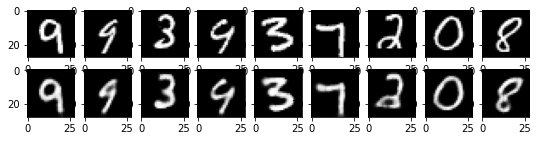

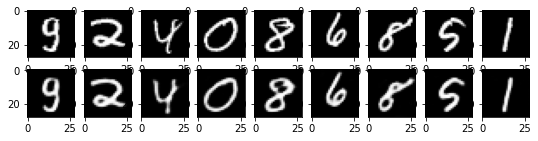

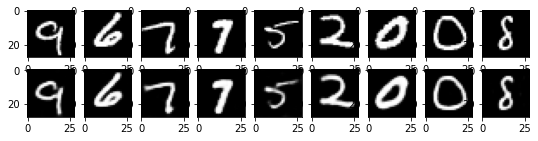

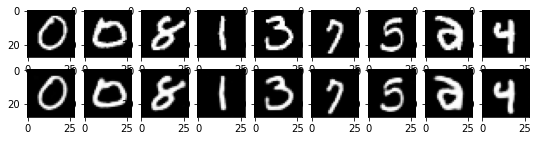

In [36]:
for k in range(0, num_epoches, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28, 28) # For Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        # item = item.reshape(-1, 28, 28) # For Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])